# Plant Disease Classification Model

## Abstract

This project focuses on developing an advanced plant disease classification model using state-of-the-art deep learning techniques. Our model is designed to accurately categorize plant leaves into five distinct classes: healthy, pest-infected, bacteria-infected, fungus-infected, and virus-infected. This tool aims to assist agriculturists, botanists, and plant enthusiasts in quickly identifying plant health issues, potentially leading to more timely and effective interventions.

## Key Features

### Jupyter Notebook Implementation

We have encapsulated our entire workflow within a Jupyter notebook, offering several advantages:

- **Reproducibility**: Anyone can replicate our results by following the step-by-step process outlined in the notebook.
- **Transparency**: Each stage of the model development process is clearly documented and explained.
- **Interactivity**: Users can modify parameters and immediately see the effects, facilitating experimentation and learning.
- **Ease of sharing**: The notebook format allows for easy distribution and collaboration among team members or with the wider community.

### Deep Learning Framework

Our model leverages the power of TensorFlow and Keras, two of the most popular and robust libraries for building neural networks:

- **TensorFlow**: Provides a flexible ecosystem of tools, libraries, and community resources, allowing us to easily build and deploy machine learning models.
- **Keras**: Offers a high-level neural networks API, running on top of TensorFlow. Its user-friendly interface allows for fast experimentation while still enabling the creation of advanced models.

These frameworks enable us to implement complex architectures, optimize performance, and take advantage of the latest advancements in deep learning research.

### Hardware Agnostic Implementation

We've designed our code to be compatible with both GPUs (Graphics Processing Units) and TPUs (Tensor Processing Units):

- **Flexibility**: This approach ensures that our model can be trained and run on a variety of hardware configurations.
- **Scalability**: As computational resources change or become available, our code can easily adapt without major modifications.
- **Accessibility**: Researchers or practitioners with access to different types of hardware can still utilize our model effectively.

### Large-Scale Dataset

Our model has been trained on a vast 25 GB image dataset, which offers several benefits:

- **Comprehensive coverage**: This extensive dataset likely includes a wide variety of plant species, diseases, and environmental conditions.
- **Improved generalization**: A large dataset helps the model learn more robust features, potentially leading to better performance on unseen data.
- **Reduced overfitting**: With more examples to learn from, the model is less likely to memorize specific images and more likely to learn general patterns.

### Transfer Learning with ResNet50

We've employed transfer learning techniques by re-training a pre-trained ResNet50 model with ImageNet weights:

- **Efficient learning**: By starting with a model pre-trained on a large dataset (ImageNet), we leverage features learned from millions of images.
- **Faster convergence**: Transfer learning often allows the model to reach high performance levels more quickly than training from scratch.
- **Improved performance**: The pre-trained weights often lead to better overall accuracy, especially when fine-tuned on a specific task like plant disease classification.

### Optimized Data Pipeline

To overcome RAM limitations and reduce training time, we've implemented an efficient data pipeline:

- **RAM management**: By loading and processing data in batches, we avoid overwhelming the system's memory, allowing for training on larger datasets than would otherwise be possible.
- **Reduced training time**: Efficient data handling and preprocessing can significantly speed up the training process.
- **Scalability**: This approach allows the model to handle even larger datasets in the future without major code changes.


## Future Work

Potential areas for improvement or expansion
- Incorporating additional plant species or disease types
- Exploring more advanced architectures or ensemble methods
- Developing a user-friendly interface for non-technical users
- Investigating the model's performance in real-world conditions

## Conclusion

This project represents a significant step forward in the application of deep learning to plant disease diagnosis. By leveraging state-of-the-art techniques and a comprehensive dataset, we've created a powerful tool that has the potential to make a real impact in agriculture and plant care.

**Note: Using [Plant Pathogens dataset](https://www.kaggle.com/datasets/sujallimje/plant-pathogens) which is licensed under CC BY-NC-SA 4.0, so The model trained using this dataset cannot be used for commercial purposes.**

## 0. Setting up basic environment

1. **Suppressing TensorFlow Autograph Verbosity:** This sets the environment variable AUTOGRAPH_VERBOSITY to '0', which reduces the verbosity of TensorFlow's Autograph feature. Autograph is a tool that converts Python code into TensorFlow's graph code, and setting verbosity to 0 minimizes the output related to this process.

```python
import os
os.environ['AUTOGRAPH_VERBOSITY'] = '0'
```

2. **Suppressing TensorFlow C++ Logs:** This sets the environment variable TF_CPP_MIN_LOG_LEVEL to '3', which suppresses all TensorFlow C++ log messages except for fatal errors. The levels are:
    - 0: All logs shown (default behavior)
    - 1: Filter out INFO logs
    - 2: Filter out WARNING logs
    - 3: Filter out ERROR logs
    
```python
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
```
3. **Suppressing Abseil Logging:** This sets the verbosity level of the Abseil logging library to ERROR, meaning only error messages will be shown, and INFO or WARNING messages will be suppressed.

```python
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
```

4. **Redirecting Standard Error Output:** This redirects the standard error stream (sys.stderr) to os.devnull, effectively silencing all error messages by sending them to a null device (a "black hole" for data). This means that any error messages that would normally be printed to the console are discarded.

```python
import sys
sys.stderr = open(os.devnull, 'w')
```

In [1]:
# if using tpu then run this
import os
os.environ['AUTOGRAPH_VERBOSITY'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
import sys
sys.stderr = open(os.devnull, 'w')


E0000 00:00:1727788529.489736      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D1001 13:15:29.497929676      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1001 13:15:29.497944197      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1001 13:15:29.497947582      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1001 13:15:29.497949966      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1001 13:15:29.497952290      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defau

In [2]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from PIL import Image # used to convert image to pil format
import tensorflow as tf
from tqdm import tqdm
import joblib  # for saving and loading the encoder
tpu=1

# 1. Creating and Preparing the dataset

We have to first create panda dataframe containing path of image and use directory of image as label to 
- perform basic EDA
- to perform necessary preprocessing
- to generate data pipeline (In later stages)

The output we are trying to achieve using `create_image_dataframe()` function. 
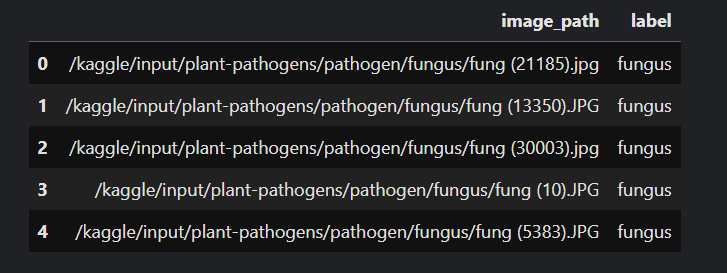

`create_image_dataframe()` function performs following operation
- Traverse dataset (`base = '/kaggle/input/plant-pathogens/pathogen'`) directory
- Gets class directory (ie `base` + bacteria,fungus,healthy,pest,virus) directory
- Traverse each image in `class` directory and
    - Get full path of image by `full_path = base + class + imgpath`
    - Create a list of `full_path`, `class` 
    - Append it in list `image_data`
    - Add extension of image in `extensions` list
- print unique extensions and number of unique extension using `extensions` list.
- Create pandas datafame `df` using `image_data` list and rename column to `img_path` and `label`.
- Return dataframe





In [3]:
import os
import pandas as pd


def create_image_dataframe(base_dir):
    image_data = [] # List to store tuples of image paths and their corresponding class labels
    extensions = [] # List to store file extensions of images
    
    # Traverse the base directory to access each class folder
    for class_name in os.listdir(base_dir):
        
        #Class directory is base_dir + class_name
        class_dir = os.path.join(base_dir, class_name) 
        
        if os.path.isdir(class_dir): # if the class_dir is directory
            
            # we will traverse class directory and read each file in the class directory
            for filename in os.listdir(class_dir): 
                file_extension = os.path.splitext(filename)[1]  # here with filename i can also use .lower() to convert JPG to jpg
                extensions.append(file_extension) #in extension list, we will append extensions like jpg,png
                img_path = os.path.join(class_dir, filename) #we will join class_dir and filename to get full image path
                image_data.append((img_path, class_name)) # we will append image path and label to create nested list
    
    df = pd.DataFrame(image_data, columns=['image_path', 'label'])
    
    # Count the occurrences of each extension
    unique_extensions, extension_counts = np.unique(extensions, return_counts=True)
    
    #The zip() function in Python is used to combine two or more iterables (like lists, tuples, or strings) element-wise into tuples 
    print("File extensions found:")
    print(list(zip(unique_extensions,extension_counts)))
    
    print(f"\nTotal files found: {len(df)}")
    return df


base_dir = "/kaggle/input/plant-pathogens/pathogen"
df = create_image_dataframe(base_dir)

print("\nLabel value counts:")
display(df['label'].value_counts())

File extensions found:
[('.JPG', 103376), ('.jpeg', 2), ('.jpg', 73363), ('.png', 3)]

Total files found: 176744

Label value counts:


label
fungus      36106
bacteria    35423
virus       35291
healthy     35134
pests       34790
Name: count, dtype: int64

In [4]:
from IPython.display import display
pd.set_option('display.max_colwidth', None)
display(df.head())  # Shows the first 5 rows
print()
display(df.sample(7))

image_path   label
0  /kaggle/input/plant-pathogens/pathogen/fungus/fung (21185).jpg  fungus
1  /kaggle/input/plant-pathogens/pathogen/fungus/fung (13350).JPG  fungus
2  /kaggle/input/plant-pathogens/pathogen/fungus/fung (30003).jpg  fungus
3     /kaggle/input/plant-pathogens/pathogen/fungus/fung (10).JPG  fungus
4   /kaggle/input/plant-pathogens/pathogen/fungus/fung (5383).JPG  fungus

image_path  \
152460    /kaggle/input/plant-pathogens/pathogen/pests/pes (18060).jpg   
159920    /kaggle/input/plant-pathogens/pathogen/pests/pes (17046).jpg   
92243    /kaggle/input/plant-pathogens/pathogen/healthy/hea (6392).JPG   
27675   /kaggle/input/plant-pathogens/pathogen/fungus/fung (15751).jpg   
141356     /kaggle/input/plant-pathogens/pathogen/virus/vir (7373).JPG   
131030    /kaggle/input/plant-pathogens/pathogen/virus/vir (32932).jpg   
29666   /kaggle/input/plant-pathogens/pathogen/fungus/fung (10797).JPG   

          label  
152460    pests  
159920    pests  
92243   healthy  
27675    fungus  
141356    virus  
131030    virus  
29666    fungus

Dataframe contains multiple extensions, so to load the image i will most probably use <a href="https://www.tensorflow.org/api_docs/python/tf/io/decode_image">`tf.io.decode_image()`</a> as it automatically detects whether an image is a BMP, GIF, JPEG, or PNG, and performs the appropriate decoding operation 

## 1.1. Loading a random image and preprocessing it (for experimentation)

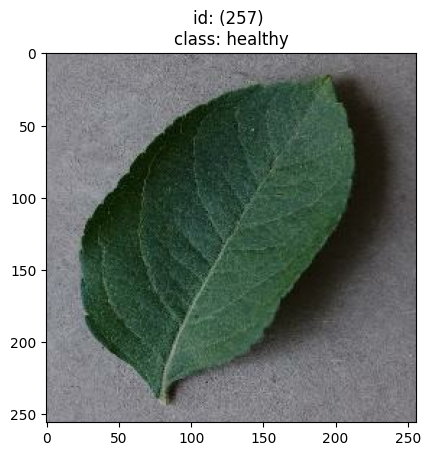

shape:  (256, 256, 3)


In [5]:

random_df_row = df.sample(1)
image_path =random_df_row['image_path'].values[0]
img= tf.io.read_file(image_path)
img= tf.io.decode_image(img,channels=3)
plt.imshow(img)
plt.title(f'id: ({image_path.split("(")[-1].split(")")[0]}) \nclass: {random_df_row["label"].values[0]}')
'''here to get the id i used split two times on that string(image_path), 
first i splitted using delimiter '(' and got a list like ['/kaggle/input/plant-pathogens/pathogen/virus/vir ', '17205).JPG']
then indexed to last element(basically second element which index is '-1' in this case element is '17205).JPG')
then i again splitted this string with delimiter ')' and got list ['17205', '.JPG'] and here i indexed to first element which is 0
'''

plt.show()
print("shape: ",img.shape)

after running the above cell multiple times, i found out that not all images are of same data shape

## 1.2. Data Transformation

### Adding a new column to the DataFrame with the image shapes

This code is used to determine the shape of images in a dataset. It defines a function `get_image_shape` that takes an image path as input and returns the shape of the image. The function uses the Python Imaging Library (PIL) to open the image and get its size and number of channels. If there is an error processing the image, the function prints an error message and returns `None`.

The code then uses the `tqdm` library to display a progress bar when applying the `get_image_shape` function to each row of a DataFrame `df`. The results are stored in a new column `image_shape` of the DataFrame.

> Here with exception handling, the functions basically returns size + number of color channels in form of
``` python
return img.size + (len(img.getbands()),)
```
PIL documentation 
- `img.size` = https://pillow.readthedocs.io/en/stable/handbook/concepts.html#size
- `img.getbands()` = https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.getbands


In [7]:
%pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 17.6 MB/s eta 0:00:00
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=a8e0b1bad560d58c414eb6d4b3ccda239b10f5a9cce1fc896794649b015c6ca8
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [8]:
import swifter

def get_image_shape(image_path):
    try:
        with Image.open(image_path) as img:
            return img.size + (len(img.getbands()),)
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None
# Enable tqdm to work with pandas(Note: i am not sure if this will work anymore because the very first cell of this notebook is redirecting sys.stderr to os.devnull,  tqdm, a popular library for progress bars in Python, primarily outputs its progress updates to stderr by default so it would indeed suppress the progress bar of tqdm)
#tqdm.pandas()
#takes around 20 min
df['image_shape'] = df['image_path'].swifter.apply(get_image_shape)


In [9]:
display(df.head())

image_path   label  \
0  /kaggle/input/plant-pathogens/pathogen/fungus/fung (21185).jpg  fungus   
1  /kaggle/input/plant-pathogens/pathogen/fungus/fung (13350).JPG  fungus   
2  /kaggle/input/plant-pathogens/pathogen/fungus/fung (30003).jpg  fungus   
3     /kaggle/input/plant-pathogens/pathogen/fungus/fung (10).JPG  fungus   
4   /kaggle/input/plant-pathogens/pathogen/fungus/fung (5383).JPG  fungus   

     image_shape  
0  (256, 256, 3)  
1  (256, 256, 3)  
2  (256, 256, 3)  
3  (256, 256, 3)  
4  (256, 256, 3)

In [10]:
# Count the occurrences of each shape
shape_counts = df['image_shape'].value_counts()

print("Image shape distribution:")
print(shape_counts)

# Get some statistics
print("\nUnique shapes:", len(shape_counts))
print("Most common shape:", shape_counts.index[0])
print("Least common shape:", shape_counts.index[-1])

# Check for any None values (failed to process)
failed_images = df[df['image_shape'].isnull()]
print(f"\nNumber of images failed to process: {len(failed_images)}")

Image shape distribution:
image_shape
(256, 256, 3)      117831
(500, 500, 3)       20764
(256, 256, 1)       10742
(6000, 4000, 3)      4370
(768, 1024, 3)       3243
                    ...  
(204, 513, 3)           1
(166, 170, 3)           1
(106, 226, 3)           1
(850, 637, 3)           1
(333, 130, 3)           1
Name: count, Length: 4796, dtype: int64

Unique shapes: 4796
Most common shape: (256, 256, 3)
Least common shape: (333, 130, 3)

Number of images failed to process: 0


### Performing Label Encoding

This code is used to convert categorical labels in a DataFrame into numerical values that can be used for machine learning algorithms. It uses the `LabelEncoder` class from the `sklearn.preprocessing` module to encode the labels.

Links:
- [`LabelEncoder`](https://scikit-learn.org/stable/modules/preprocessing.html)
- [`sklearn.preprocessing`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

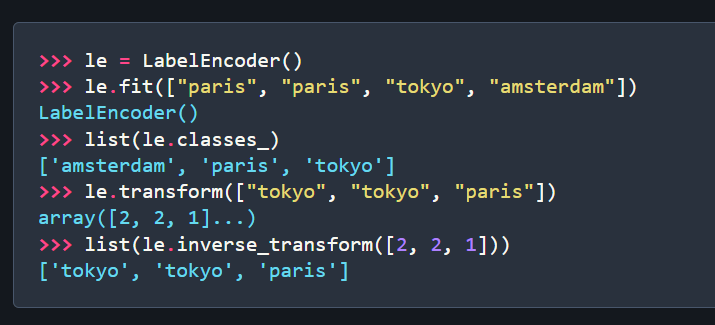

#### performing label encoding on classification labels 

In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assuming your DataFrame is named 'df'

# Create a LabelEncoder object
le = LabelEncoder()

# Fit the encoder to your labels and transform them
df['encoded_label'] = le.fit_transform(df['label'])

# Display the first few rows to verify the new column
display(df.head())

# If you want to see the mapping between original labels and encoded values
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
display("Label Mapping:", label_mapping)

# Get some basic statistics about the new column
print(df['encoded_label'].describe())

image_path   label  \
0  /kaggle/input/plant-pathogens/pathogen/fungus/fung (21185).jpg  fungus   
1  /kaggle/input/plant-pathogens/pathogen/fungus/fung (13350).JPG  fungus   
2  /kaggle/input/plant-pathogens/pathogen/fungus/fung (30003).jpg  fungus   
3     /kaggle/input/plant-pathogens/pathogen/fungus/fung (10).JPG  fungus   
4   /kaggle/input/plant-pathogens/pathogen/fungus/fung (5383).JPG  fungus   

     image_shape  encoded_label  
0  (256, 256, 3)              1  
1  (256, 256, 3)              1  
2  (256, 256, 3)              1  
3  (256, 256, 3)              1  
4  (256, 256, 3)              1

'Label Mapping:'

{'bacteria': 0, 'fungus': 1, 'healthy': 2, 'pests': 3, 'virus': 4}

count    176744.000000
mean          1.991061
std           1.414717
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max           4.000000
Name: encoded_label, dtype: float64


#### Saving and retrieving the dataframe and the label encoder


In [12]:
df.to_csv('image_data.csv', index=False)
print("DataFrame saved successfully.")
joblib.dump(le, 'label_encoder.joblib')
print("label encoder saved successfully")

DataFrame saved successfully.
label encoder saved successfully


In [13]:
df = pd.read_csv('image_data.csv')
print("DataFrame loaded successfully.")
print(df.info())

le = joblib.load('label_encoder.joblib')
print("label encoder loaded successfully")
encoded_predictions = [0, 1, 2, 3, 4] #taking as an example
decoded_prediction = le.inverse_transform(encoded_predictions)
print("Original labels:", decoded_prediction)

DataFrame loaded successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176744 entries, 0 to 176743
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   image_path     176744 non-null  object
 1   label          176744 non-null  object
 2   image_shape    176744 non-null  object
 3   encoded_label  176744 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 5.4+ MB
None
label encoder loaded successfully
Original labels: ['bacteria' 'fungus' 'healthy' 'pests' 'virus']


### Preprocessing on single image for experimentation


Normalization scales the values of numeric columns in a dataset to a common range, typically between 0 and 1, without distorting differences in the ranges of values.
Standardization rescales data to have a mean of 0 and a standard deviation of 1, giving the data properties of a standard normal distribution.
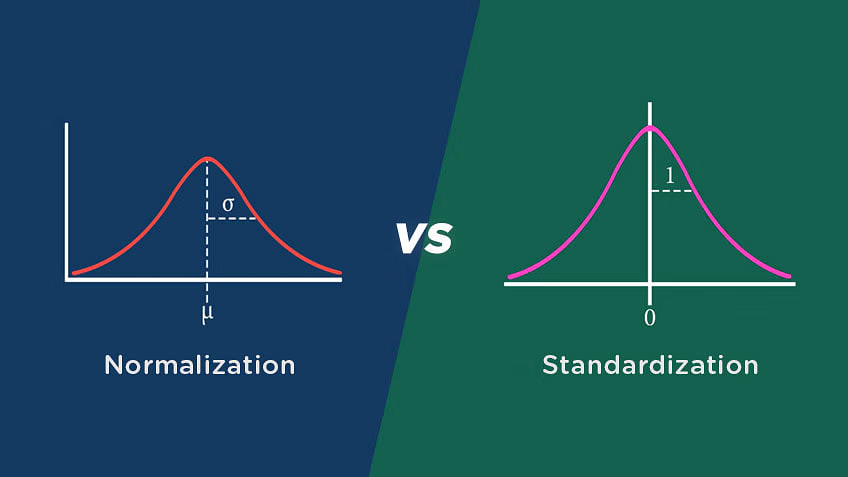

|Aspect|Normalization|Standardization|
|---|---|---|
|Range|Fixed (e.g., [0, 1])|Unbounded|
|Distribution|Preserves original shape|Centers around zero|
|Outliers|Less sensitive|More sensitive|
|Common in|Image processing, neural networks|General machine learning, clustering|


### Appying image transformation on single image for experimentation

Here to transform whole dataset, we first should apply transformation any random few images to get hang of what our code is doing and how it is affecting our image individually. Using this information, we can decide the input size of layer and and tune our deep learning model and re pre-processess our dataset on bigger resolution if needed.

#### A. Grayscale to RGB conversion
Firstly the image which are grayscale is converted into rgb using [`tf.image.grayscale_to_rgb`](https://www.tensorflow.org/api_docs/python/tf/image/grayscale_to_rgb) function
The code checks if the input image is grayscale (i.e., has only one channel). If it is, the code converts the image to RGB by repeating the channel three times. This is necessary because many machine learning models expect input images to have three channels (red, green, and blue).

#### B. Check image properties
The `check_image_properties` function is defined to check the properties of an input image. The function prints the data type of the image, the minimum and maximum values of the image, and whether the image is 8-bit and whether its values are in the 0-255 range.

#### C. Resize and Standardize image function
The `resize_and_pad_image` function is defined to resize an input image to a target size of `124x124` pixels using bilinear interpolation. [`tf.image.resize_with_pad()`](https://www.tensorflow.org/api_docs/python/tf/image/resize_with_pad) code is used along with `tf.image.ResizeMethod.BILINEAR` interpolation. 

The function also applies standardization to the image by subtracting the mean and dividing by the standard deviation of each pixel. The function returns both the resized and standardized images.

https://www.tensorflow.org/api_docs/python/tf/image/resize

#### D. Lastly we normalize the image by dividing it by 255.0 (or maximum value of pixel)



Info on original image: 
Image data type: <dtype: 'uint8'>
Minimum value: 0
Maximum value: 182
Image is 8-bit
Image values are in 0-255 range

Info on resized and normalized image: 
Image data type: <dtype: 'float32'>
Minimum value: 0.0
Maximum value: 0.6752159595489502
Image is not 8-bit
Image values are in 0-255 range


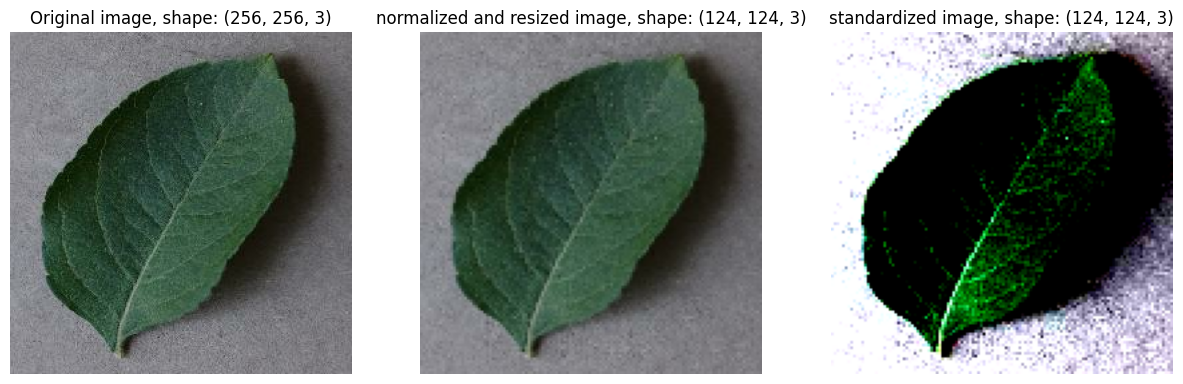

In [14]:
# Check if the image is grayscale (1 channel)
if tf.shape(img)[-1] == 1:
    # If it's grayscale, repeat the channel 3 times to make it RGB
    img = tf.image.grayscale_to_rgb(img)

    
import tensorflow as tf

def check_image_properties(image):
    # Check data type
    dtype = image.dtype
    print(f"Image data type: {dtype}")

    # Check value range
    min_val = tf.reduce_min(image)
    max_val = tf.reduce_max(image)
    print(f"Minimum value: {min_val}")
    print(f"Maximum value: {max_val}")

    # Check if 8-bit
    if dtype == tf.uint8:
        print("Image is 8-bit")
    else:
        print("Image is not 8-bit")

    # Check if values are in 0-255 range
    if min_val >= 0 and max_val <= 255:
        print("Image values are in 0-255 range")
    else:
        print("Image values are not in 0-255 range")

print("Info on original image: ")
check_image_properties(img)
def resize_and_pad_image(image, target_size=(124, 124)):
    resized_image = tf.image.resize_with_pad(
        image, 
        target_size[0], 
        target_size[1], 
        method=tf.image.ResizeMethod.BILINEAR #Bilinear interpolation is a resampling technique that uses the weighted average of four nearest pixel values to estimate a new pixel value when resizing an image
    )
    
    # Apply standardization
    standardized_image = tf.image.per_image_standardization(resized_image)
    
    return resized_image,standardized_image

resized_img,standardized_image= resize_and_pad_image(img)

image = tf.cast(resized_img, tf.float32)/255.0
print("\nInfo on resized and normalized image: ")
check_image_properties(image)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img)
axes[0].set_title(f'Original image, shape: {img.shape}')
axes[0].axis('off') 

axes[1].imshow(image)
axes[1].set_title(f'normalized and resized image, shape: {image.shape}')
axes[1].axis('off') 

axes[2].imshow(standardized_image)
axes[2].set_title(f'standardized image, shape: {standardized_image.shape}')
axes[2].axis('off') 

plt.show()


In [15]:
!rm -rf /kaggle/temp_0.lockfile

### Creating a Temporary Folder in Kaggle

- Anything written in the temporary folder won't count towards disk space.
- There is no persistence in the temporary folder, i.e., the contents will be erased after the session.
- It is useful for temporary caching.
- Both read and write permissions are granted in the temporary folder.

In [16]:
temp_dir = "/kaggle/temp"
os.makedirs(temp_dir, exist_ok=True)


# Data Pipeline Documentation

## Overview
This document explains a TensorFlow data pipeline for image processing and augmentation. The pipeline is designed to efficiently load, preprocess, and augment image data for machine learning tasks, particularly for training neural networks on image datasets.

## Main Function: `dataset_pipeline`
The `dataset_pipeline` function creates a TensorFlow dataset pipeline for image processing and augmentation. Here's a breakdown of its components and functionality:

### Function Signature
```python
def dataset_pipeline(df, batch_size, target_size, shuffle=True, augment=False, cache=False, temp_dir=None):
```

### Parameters:
- `df`: DataFrame containing image paths and labels
- `batch_size`: Size of batches to create
- `target_size`: Desired size of the output images
- `shuffle`: Whether to shuffle the dataset (default: True)
- `augment`: Whether to apply data augmentation (default: False)
- `cache`: Whether to cache the dataset (default: False)
- `temp_dir`: Directory for caching, if used (default: None)

### Pipeline Components

1. **Image Generator**
```python
def image_generator(dataframe):
    for _, row in dataframe.iterrows():
        yield row['image_path'], row['encoded_label']
```
- Yields image paths and labels from the input DataFrame.

2. **Image Preprocessing**
```python
def preprocess_image(image_path, label, target_size):
    # ... (image loading and preprocessing code)
```
- Uses `Image.open` from PIL instead of `tf.io.decode_image` due to the presence of very high-resolution images in the plant-pathognes dataset but this adds Python overhead
- Loads images using a Python function
- Resizes images with padding to the target size
- Normalizes pixel values to the range [0, 1]

3. **Data Augmentation**
```python
def augment_image(image, label):
    # ... (various augmentation techniques)
```
- Applies random transformations:
  - Horizontal and vertical flips
  - Brightness, contrast, saturation, and hue adjustments
  - Center cropping and resizing

### Pipeline Construction
The main pipeline is constructed using TensorFlow's `tf.data` API:

1. **Create Dataset**
```python
dataset = tf.data.Dataset.from_generator(gen, output_signature=(...))
```
- Initializes a dataset from the image generator

2. **Apply Shuffling**
```python
if shuffle:
    dataset = dataset.shuffle(buffer_size=10000)
```
- Shuffles the dataset if specified

3. **Apply Preprocessing**
```python
dataset = dataset.map(lambda x, y: preprocess_image(x, y, target_size), num_parallel_calls=tf.data.experimental.AUTOTUNE)
```
- Maps the `preprocess_image` function to each element in parallel

4. **Apply Caching** (if specified)
```python
if cache:
    dataset = dataset.cache(temp_dir)
```
5. **Again Applying Shuffling** (if specified)

- first shuffle was applied before caching so it will only shuffle for first epoch, to shuffle for next epochs, applying shuffling again after caching because when caching is enabled, the dataset gets cached after the first epoch, and subsequent epochs would use the cached (and thus unshuffled) data if we don't shuffle after caching.

6. **Apply Data Augmentation** (if specified)
```python
if augment:
    dataset = dataset.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
```

7. **Batch the Dataset**
```python
dataset = dataset.batch(batch_size)
```

8. **Enable Prefetching**
```python
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
```
- Overlaps data processing and model execution for better performance

## Key Advantages of this Pipeline
1. **Efficiency**: Utilizes TensorFlow's `tf.data` API for optimal performance.
2. **Flexibility**: Allows customization of preprocessing and augmentation steps.
3. **Scalability**: Can handle large datasets through streaming and efficient memory usage.
4. **Performance Optimization**: Implements shuffling, caching, and prefetching for improved training speed.
5. **Parallelism**: Uses parallel processing for data loading and augmentation.
6. **High-Resolution Image Handling**: Uses PIL's `Image.open` for loading very high-resolution images in the plant-pathognes dataset.
7. **Continuous Shuffling**: Ensures data is shuffled after each epoch, maintaining randomness throughout training.

This pipeline provides a robust foundation for image-based machine learning tasks, ensuring efficient data handling and preprocessing for model training, particularly suited for datasets with high-resolution images like plant-pathognes.

In [17]:
# Note: plant-pathognes dataset contains very high resolution images.
# We prefer tf.io.decode_image over PIL.Image for tf.data pipeline efficiency.
# Only use PIL method if you don't have any other option, as it adds Python overhead.

def dataset_pipeline(df,batch_size,target_size,shuffle=True,augment=False,cache=False,temp_dir=None):
    
    def image_generator(dataframe):
        for _, row in dataframe.iterrows():
            yield row['image_path'],row['encoded_label']
    
    def preprocess_image(image_path,label,target_size):
        #img= tf.io.aread_file(image_path)
        #img= tf.io.decode_jpeg(img,channels=3)
        #img = tf.io.decode_image(img, channels=3)
        
        def _preprocess(image_path_tensor):
            image_path = image_path_tensor.numpy().decode('utf-8')
            try:
                with tf.io.gfile.GFile(image_path, 'rb') as file:
                    img = Image.open(file).convert("RGB")
                img = np.array(img)
                return img
            except Exception as e:
                print(f"Error processing image {image_path}: {str(e)}")
                # Return a placeholder image (e.g., black image) of the target size
                return np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8)
        img = tf.py_function(_preprocess, [image_path], tf.uint8)
        img.set_shape((None, None, 3))
        #if tf.shape(img)[-1] == 1:
            # If it's grayscale, repeat the channel 3 times to make it RGB
         #   img = tf.image.grayscale_to_rgb(img)
        img = tf.image.resize_with_pad(
        img, 
        target_size[0], 
        target_size[1], 
        method=tf.image.ResizeMethod.BILINEAR
    )
        img = tf.cast(img, tf.float32)/255.
        return img,label
    
    
    def center_crop_and_resize(image):
        # Get original dimensions
        original_shape = tf.shape(image)

        # Perform center crop
        cropped_image = tf.image.central_crop(image, central_fraction=0.9)

        # Resize back to original dimensions
        resized_image = tf.image.resize(cropped_image, [original_shape[0], original_shape[1]])

        return resized_image


    
    def augment_image(image, label):
        def apply_with_probability(x, func, prob=0.5):
            return tf.cond(tf.less(tf.random.uniform([], 0, 1), prob), lambda: func(x), lambda: x)
        
        image = apply_with_probability(image, tf.image.random_flip_left_right, prob=0.5)
        image = apply_with_probability(image, tf.image.random_flip_up_down, prob=0.5)
        image = apply_with_probability(image, lambda img: tf.image.random_brightness(img, max_delta=0.1), prob=0.5)
        image = apply_with_probability(image, lambda img: tf.image.random_contrast(img, lower=0.8, upper=1.2), prob=0.5)
        image = apply_with_probability(image, lambda img: tf.image.random_saturation(img, lower=0.8, upper=1.2), prob=0.5)
        image = apply_with_probability(image, lambda img: tf.image.random_hue(img, max_delta=0.02), prob=0.5)
        image = apply_with_probability(image, center_crop_and_resize, prob=0.5)
        
        return image, label
    
    #create generator function
    gen = lambda: image_generator(df)
    
    #create dataset from the generator
    dataset = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )
    
    
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)
    
    dataset = dataset.map(
        lambda x, y: preprocess_image(x, y,target_size),
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    if cache:
        if temp_dir != None:
            dataset = dataset.cache(temp_dir)
        else: 
            dataset = dataset.cache()
    #applied shuffling after caching
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)        
    
    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # Batch the dataset
    dataset = dataset.batch(batch_size)
    
    # Prefetch for performance
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
   
    
    return dataset

## Splitting into train,test,dev dataset (will apply same dataset pipeline on all 3)

In [18]:
from sklearn.model_selection import train_test_split

# First split: separate test set
train_val_df, test_df = train_test_split(df, test_size=0.05, stratify=df['encoded_label'])

# Second split: separate dev set from remaining data
train_df, dev_df = train_test_split(train_val_df, test_size=0.1, stratify=train_val_df['encoded_label'])

In [19]:
batch_size_gpu=128
batch_size_tpu=128
target_size=(256,256)

In [20]:
if tf.config.list_physical_devices('GPU'):
    gpu_strategy = tf.distribute.MirroredStrategy()
    with gpu_strategy.scope():

        train_dataset = dataset_pipeline(train_df, batch_size_gpu, target_size, shuffle=True, augment=True, cache=False,temp_dir="/kaggle/temp/train")
        dev_dataset = dataset_pipeline(dev_df, batch_size_gpu, target_size, shuffle=False, augment=False, cache=False,temp_dir="/kaggle/temp/dev")
        test_dataset = dataset_pipeline(test_df, batch_size_gpu, target_size, shuffle=False, augment=False, cache=False ,temp_dir="/kaggle/temp/test")
        
        train_dataset = gpu_strategy.experimental_distribute_dataset(train_dataset)
        dev_dataset = gpu_strategy.experimental_distribute_dataset(dev_dataset)
        test_dataset = gpu_strategy.experimental_distribute_dataset(test_dataset)
        
        

try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    if tpu==1:
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        tpu=0
    tpu_strategy = tf.distribute.TPUStrategy(resolver)
    print("All TPU devices: ", tf.config.list_logical_devices('TPU'))
    
    with tpu_strategy.scope():
        train_dataset = dataset_pipeline(train_df, batch_size_tpu, target_size, shuffle=True, augment=False, cache=True)
        dev_dataset = dataset_pipeline(dev_df, batch_size_tpu, target_size, shuffle=False, augment=False, cache=True)
        test_dataset = dataset_pipeline(test_df, batch_size_tpu, target_size, shuffle=False, augment=False, cache=True)
        
        train_dataset = tpu_strategy.experimental_distribute_dataset(train_dataset)
        dev_dataset = tpu_strategy.experimental_distribute_dataset(dev_dataset)
        test_dataset = tpu_strategy.experimental_distribute_dataset(test_dataset)
except (ValueError, tf.errors.NotFoundError) as e:
    print(f"No TPU found or initialization failed: {e}. Skipping TPU training.")

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

## 2. Creating Model and training

In [22]:
%pip install visualkeras


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


### 2.1 Using NASNet Model



**Note:** NASNetMobile uses cell-based modular structures that were optimized for accuracy through Neural Architecture Search (NAS). This results in deeper and more convoluted computational paths, leading to an increased number of FLOPs (Floating Point Operations) compared to simpler architectures like ResNet50. While ResNet50 relies on standard convolutional and residual connections that are easier to parallelize, NASNetMobile introduces more complex operations and cross-connections. This is why, despite having fewer parameters, it demands more training time. But NasNetMobile inference time could be much lower than ResNet50

**NasNet Paper:** https://paperswithcode.com/model/nasnet?variant=nasnetalarge#

**Resnet Paper**: [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)

**EfficientNetV2 Paper**: [EfficientNetV2: Smaller Models and Faster Training](https://arxiv.org/abs/2104.00298)


In [23]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate
from tensorflow.keras.optimizers import Adam,AdamW,SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, LeakyReLU, Flatten, Input, Dropout, BatchNormalization
from tensorflow.keras.applications import NASNetLarge, NASNetMobile
from tensorflow.keras.applications import EfficientNetV2S, EfficientNetV2M, EfficientNetV2L


def create_model(target_size, num_classes=5):
    # Load the pre-trained model without the top layers
    #change the model accordingly from [NASNetMobile,ResNet50]
    base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))
    
    
    
    
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)
    
  
    # Compile the model
    #optimizer = Adam(learning_rate=0.001)
    optimizer = AdamW(learning_rate=2e-5,weight_decay=6e-4)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model



In [24]:
if tf.config.list_physical_devices('GPU'):
    with gpu_strategy.scope():
        model= create_model(target_size)

if tf.config.list_logical_devices('TPU'):
    with tpu_strategy.scope():
        model= create_model(target_size)

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [25]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv1 (Conv2D) │ (None, 127, 127,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn1            │ (None, 127, 127,  │        128 │ stem_conv1[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 127, 127,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_conv_1_s… │ (None, 127, 127,  │        352 │ activation[0][0]  │
│ (Conv2D)            │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_bn_1_ste… │ (None, 127, 127,  │         44 │ reduction_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 127, 127,  │          0 │ reduction_bn_1_s… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 127, 127,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 131, 131,  │          0 │ activation_1[0][… │
│ (ZeroPadding2D)     │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 133, 133,  │          0 │ activation_3[0][… │
│ (ZeroPadding2D)     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 64, 64,    │        396 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 64, 64,    │      1,920 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 64, 64,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 64, 64,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 64,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_2_r… │ (None, 64, 64,    │        396 │ activation_2[0][

 Total params: 4,275,001 (16.31 MB)

 Trainable params: 4,238,263 (16.17 MB)

 Non-trainable params: 36,738 (143.51 KB)

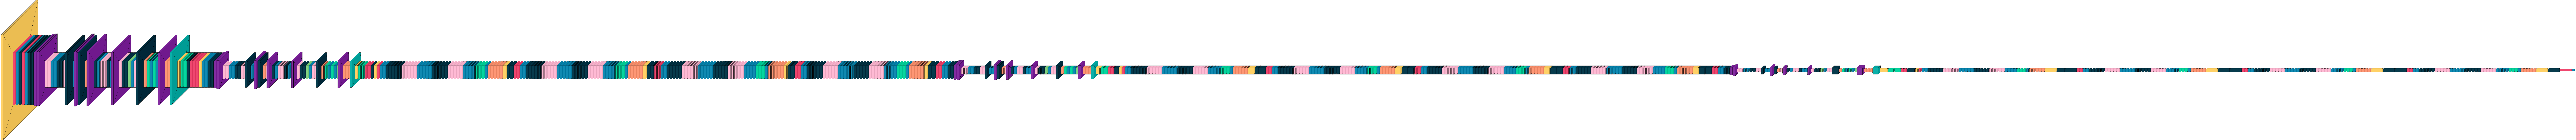

In [26]:
import visualkeras
visualkeras.layered_view(model)

In [27]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras import callbacks
# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)


In [28]:
if tf.config.list_physical_devices('GPU'):
    with gpu_strategy.scope():
        history = model.fit(train_dataset, validation_data=dev_dataset, epochs=5,callbacks=[reduce_lr])
        # Evaluate on the test set
        test_accuracy = model.evaluate(test_dataset, verbose=1)  

if tf.config.list_logical_devices('TPU'):
    with tpu_strategy.scope():
        model.fit(train_dataset, validation_data=dev_dataset, epochs=10,callbacks=[reduce_lr,early_stopping])
        test_accuracy = model.evaluate(test_dataset, verbose=1)


Epoch 1/10
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 2115s 1s/step - accuracy: 0.6307 - loss: 0.9817 - val_accuracy: 0.7766 - val_loss: 0.6406 - learning_rate: 2.0000e-05
Epoch 2/10
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 424s 358ms/step - accuracy: 0.8627 - loss: 0.3900 - val_accuracy: 0.8614 - val_loss: 0.3985 - learning_rate: 2.0000e-05
Epoch 3/10
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 422s 356ms/step - accuracy: 0.8945 - loss: 0.2940 - val_accuracy: 0.8923 - val_loss: 0.3069 - learning_rate: 2.0000e-05
Epoch 4/10
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 422s 357ms/step - accuracy: 0.9100 - loss: 0.2515 - val_accuracy: 0.9247 - val_loss: 0.2157 - learning_rate: 2.0000e-05
Epoch 5/10
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 423s 357ms/step - accuracy: 0.9321 - loss: 0.1898 - val_accuracy: 0.9443 - val_loss: 0.1634 - learning_rate: 2.0000e-05
Epoch 7/10
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 422s 357ms/step - accuracy: 0.9409 - loss: 0.1605 - val_accuracy: 0.9438 - val_loss: 0.1650 - learning_rate: 2.0000e-05
Epoch 8/10
1181/1181 ━━━━━━━━━

In [29]:
if tf.config.list_logical_devices('TPU'):
    with tpu_strategy.scope():
        model.fit(train_dataset, validation_data=dev_dataset, epochs=15,callbacks=[reduce_lr,early_stopping])
        test_accuracy = model.evaluate(test_dataset, verbose=1)

Epoch 1/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 433s 366ms/step - accuracy: 0.9557 - loss: 0.1241 - val_accuracy: 0.9562 - val_loss: 0.1230 - learning_rate: 2.0000e-05
Epoch 2/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 432s 365ms/step - accuracy: 0.9558 - loss: 0.1263 - val_accuracy: 0.9581 - val_loss: 0.1192 - learning_rate: 2.0000e-05
Epoch 3/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 433s 366ms/step - accuracy: 0.9592 - loss: 0.1128 - val_accuracy: 0.9619 - val_loss: 0.1101 - learning_rate: 2.0000e-05
Epoch 4/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 431s 365ms/step - accuracy: 0.9626 - loss: 0.1019 - val_accuracy: 0.9628 - val_loss: 0.1091 - learning_rate: 2.0000e-05
Epoch 5/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 435s 368ms/step - accuracy: 0.9674 - loss: 0.0908 - val_accuracy: 0.9614 - val_loss: 0.1054 - learning_rate: 2.0000e-05
Epoch 6/15
1181/1181 ━━━━━━━━━━━━━━━━━━━━ 432s 365ms/step - accuracy: 0.9671 - loss: 0.0922 - val_accuracy: 0.9595 - val_loss: 0.1102 - learning_rate: 2.0000e-05
Epoch 7/15
1181/1181 ━━━━━━━

## saving the model 

In [ ]:
os.makedirs("/kaggle/working/models",exist_ok=True)

In [30]:
if tf.config.list_logical_devices('TPU'):
    with tpu_strategy.scope():
        model.save("/kaggle/working/models/NasNetMobile.keras")

In [31]:
if tf.config.list_logical_devices('TPU'):
    with tpu_strategy.scope():
        model.save("/kaggle/working/models/NasNetMobile.h5")

In [32]:
from keras.models import load_model
if tf.config.list_logical_devices('TPU'):
    with tpu_strategy.scope():
        model = load_model("/kaggle/working/models/NasNetMobile.keras")

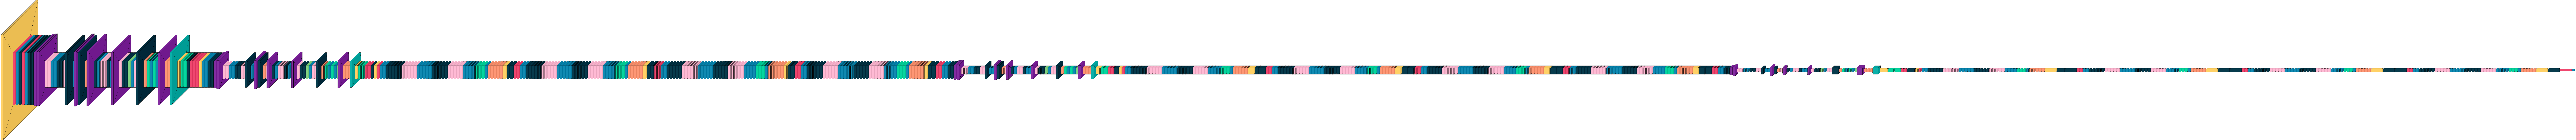

In [33]:
visualkeras.layered_view(model)

In [34]:
from IPython.display import FileLink

In [35]:
FileLink(r'models/NasNetMobile.keras')

/kaggle/working/models/NasNetMobile.keras